In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("insurance.csv")

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

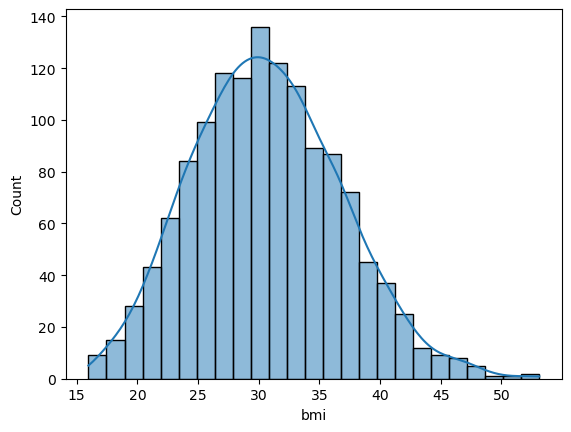

In [18]:
sns.histplot(data=df, x="bmi", kde=True)
plt.show()

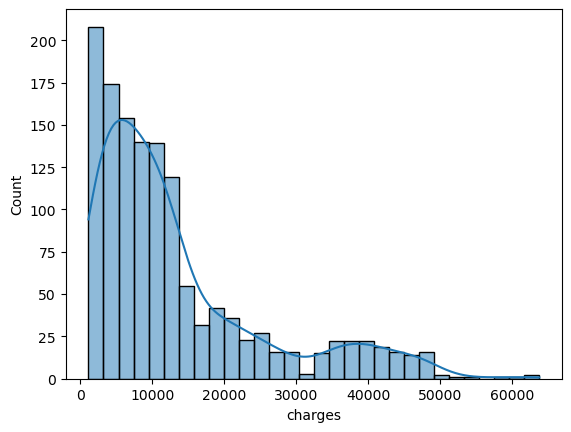

In [19]:
sns.histplot(data=df, x="charges", kde=True)
plt.show()

<Axes: xlabel='age', ylabel='Count'>

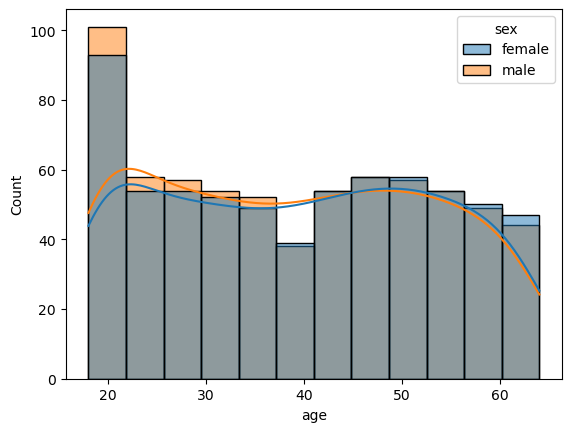

In [9]:
sns.histplot(data=df,x="age",hue="sex",kde=True)

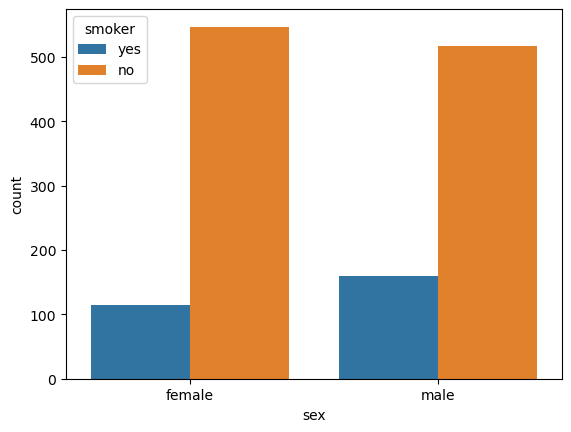

In [7]:
sns.countplot(data=df, x="sex",hue="smoker")
plt.show()

([<matplotlib.patches.Wedge at 0x2220719fe00>,
 [Text(-0.8801026865408975, 0.6598630624178738, 'no'),
  Text(0.8801029015515279, -0.6598627756439833, 'yes')],
 [Text(-0.4800560108404895, 0.3599253067733857, '79.52'),
  Text(0.48005612811901516, -0.3599251503512636, '20.48')])

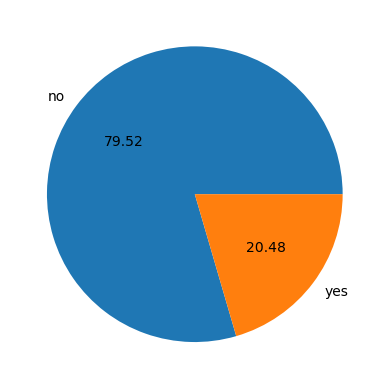

In [13]:
plt.pie(x=df["smoker"].value_counts(),labels=df["smoker"].value_counts().index,autopct='%.2f')

<Axes: xlabel='children', ylabel='Count'>

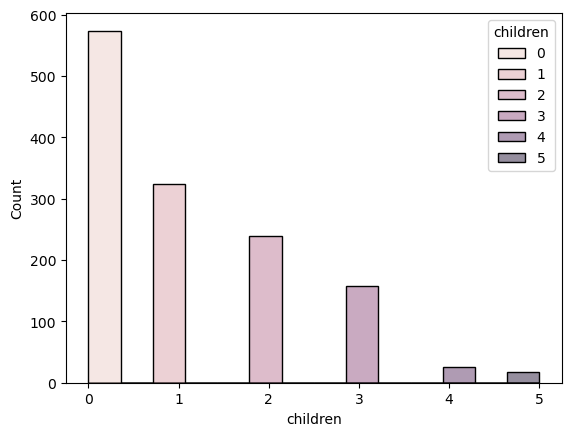

In [14]:
sns.histplot(data=df,x="children",hue="children")

<Axes: xlabel='region', ylabel='Count'>

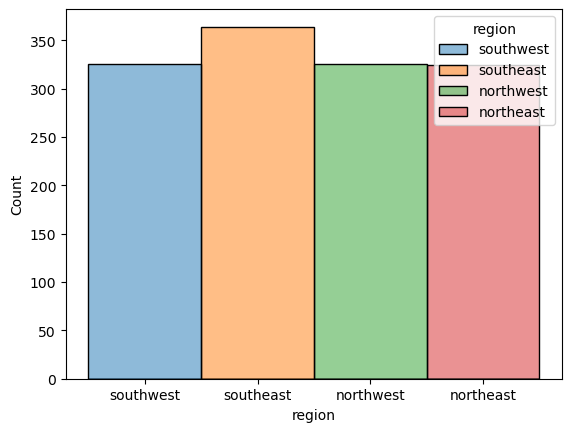

In [17]:
sns.histplot(data=df,x="region",hue="region")

In [21]:
df["sex"] = df["sex"].map({"male" : 0, "female": 1})
df["smoker"] = df["smoker"].map({"no" : 0, "yes": 1})

In [22]:
df["sex"].value_counts()

sex
0    676
1    662
Name: count, dtype: int64

In [23]:
df["smoker"].value_counts()

smoker
0    1064
1     274
Name: count, dtype: int64

In [24]:
X = df.drop("charges", axis=1)
y = df["charges"]

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 15)

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
categorical_cols = ["region"]
preprocessor = ColumnTransformer(transformers=
                                [
                                    ('cat', OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
                                ], remainder= "passthrough"
                                )

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [27]:
from lightgbm import LGBMRegressor

In [28]:
model = LGBMRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 1003, number of used features: 8
[LightGBM] [Info] Start training from score 13374.181390


In [30]:
from sklearn.metrics import r2_score, mean_squared_error
print(r2_score(y_pred, y_test))
print(mean_squared_error(y_pred, y_test))

0.8636669836215215
18458085.613847945


In [31]:
param_grid = {
    "num_leaves" : [31, 50, 70],
    "max_depth" : [-1, 5, 10],
    "learning_rate" : [0.01, 0.05, 0.1],
    "n_estimators" : [100, 300, 1000],
    "min_child_samples" : [10,20,30],
    "subsample" : [0.6, 0.8, 1.0],
    "colsample_bytree" : [0.6, 0.8, 1.0],
    "reg_alpha" : [0, 0.5, 1.0],
    "reg_lambda" : [0, 0.5, 1.0]
}

In [32]:
from sklearn.model_selection import RandomizedSearchCV

In [37]:
random_search = RandomizedSearchCV(
    estimator=LGBMRegressor(verbosity=-1),
    param_distributions=param_grid,
    cv=5,
    verbose=0,
    random_state=15,
    scoring="neg_root_mean_squared_error",
)

In [38]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(verbosity=-1),
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [-1, 5, 10],
                                        'min_child_samples': [10, 20, 30],
                                        'n_estimators': [100, 300, 1000],
                                        'num_leaves': [31, 50, 70],
                                        'reg_alpha': [0, 0.5, 1.0],
                                        'reg_lambda': [0, 0.5, 1.0],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=15, scoring='neg_root_mean_squared_error')

In [39]:
random_search.best_params_

{'subsample': 0.6,
 'reg_lambda': 1.0,
 'reg_alpha': 0.5,
 'num_leaves': 50,
 'n_estimators': 100,
 'min_child_samples': 30,
 'max_depth': -1,
 'learning_rate': 0.1,
 'colsample_bytree': 0.8}

In [40]:
y_pred = random_search.predict(X_test)
print(r2_score(y_pred, y_test))
print(mean_squared_error(y_pred, y_test))

0.8775521864086795
16446549.93278381


In [41]:
from scipy.stats import boxcox
y_train_transformed, lambda_y = boxcox(y_train)